In [1]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers
import matplotlib.pyplot as plt
from keras import optimizers
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['coverage', 'sort-bugxjy']


In [ ]:
coverage = pd.read_csv('../input/sort-bugXJY/sort_bug1.csv')
coverage # check coverage information

In [2]:
def read_coverage(inputstream):
    coverage = pd.read_csv(inputstream)
    rows, columns = coverage.shape
    m = coverage[coverage.columns[1:-1]]
    m = np.matrix(m)
    result = coverage[coverage.columns[-1]]
    result = np.array(result)
    return m, result, columns-2

In [7]:
#######################################
#           Procedure I               #
#######################################

def get_train_data(): # simulate, example in BPNN paper
    m = np.matrix([
        [1,1,1,1,0,1,0,0,1],
        [1,0,0,0,1,1,1,1,0],
        [0,0,0,0,0,1,1,0,0],
        [1,1,0,0,1,0,1,1,1],
        [1,1,1,0,1,1,1,1,1],
        [0,0,1,0,0,1,1,1,0],
        [1,1,1,1,0,1,0,1,1]
    ]).astype(int)
    result = np.array([0,0,0,0,0,1,1])
    return m, result

def create_virtual_test(n):
    c = np.diag(np.ones(n-1), 1) 
    return c

def build_model(n_statement):
    model = Sequential()
    # input layer is m.size
    # hidden layer one
    initiallizer = initializers.RandomUniform(minval=-0.01*n_statement, maxval=0.01*n_statement, seed=None)
    model.add(Dense(3, input_dim=n_statement, activation='relu', 
                    kernel_initializer= initiallizer,
                    bias_initializer='zeros',
                    kernel_regularizer=regularizers.l2(0.01)))
    # hidden layer 
#     model.add(Dense(3, activation='sigmoid', 
#                     kernel_regularizer=regularizers.l2(0.01)
#                    ))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model    


def train_model(m,result,n_statement,epochs, lr):
    model = build_model(n_statement)
    #sgd = optimizers.SGD(lr=0.3, decay=1e-6, momentum=0.9, nesterov=True)
    rmsprop = optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer= rmsprop, metrics=['accuracy'])
    history = model.fit(m, result, epochs=epochs) #  batch_size=10

    # summarize history for accuracy
#     plt.plot(history.history['acc'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return model

def selectionSort(rlist):
    index = [x for x in range(len(rlist))]
    rank = [x for x in range(len(rlist))]
    for i in range(len(index)):
        idx = i
        j = i+1
        while j > i and j < len(index):
            if (rlist[idx] < rlist[j]):
                idx = j
            j+=1
        rlist[i],rlist[idx] = swap(rlist[i],rlist[idx])
        index[i], index[idx] = index[idx], index[i]
        i+=1
    return rank, index

def swap(a,b): # just for np.array
    temp = a.copy()
    a = b
    b = temp
    return a, b

#######################################
#           Procedure II              #
#######################################

def find_si(m, result, n_statement):
    si = np.zeros(n_statement)
    for i in range(result.size):
        if result[i] == 0:  
            continue
        for j in range(n_statement):
            if m[i,j] == 0: 
                si[j]-=10000 # assume n_statement < 10000
            else:
                si[j]+=1
    for j in range(n_statement):
        if (si[j] <= 0): si[j] = 0
        else: si[j] = 1
    return si

def find_sm(m, result):
    t = np.zeros(result.size)
    minidx = 0
    minsum = 10000 # assume n_statement < 10000
    for i in range(result.size):
        if result[i] == 0:  
            continue
        t[i] = np.sum(m[i])
        if t[i] < minsum:
            minsum = t[i]
            minidx = i
    sm = m[minidx]
    return sm

def procedure1(r_virtual):
    r_virtual1 = r_virtual.copy()
    rank, index= selectionSort(r_virtual1)
    print("Procedure I")
    for i in range(len(rank)):
        print("Statement {:>2}: {:>4}".format(index[i]+1,rank[i]+1))
        
def procedure2(r_virtual): # improvement suggested in paper
    r_virtual2 = r_virtual.copy()
    print("Procedure II (improvement)")
    # Procedure II
    si = find_si(m,result,n_statement)
    sm = find_sm(m,result)
    for i in range(len(si)):
        if(si[i] != 0 and sm[0,i] != 0):
            r_virtual2[i] +=2.0
            print("Statement {:>2} should be checked firstly (Si)".format(i+1))
        if(si[i] == 0 and sm[0,i] == 1):
            r_virtual2[i] +=1.0
            print("Statement {:>2} should be checked secondly (Sm)".format(i+1))
    rank, index= selectionSort(r_virtual2)
    print("Final Result")
    for i in range(len(rank)):
        print("Statement {:>2}: {:>4}".format(index[i]+1,rank[i]+1))
    

Epoch 1/3000
300/300 [==============================] - 0s 851us/step - loss: 0.7809 - acc: 0.8967
Epoch 2/3000
300/300 [==============================] - 0s 47us/step - loss: 0.2817 - acc: 0.9867
Epoch 3/3000
300/300 [==============================] - 0s 46us/step - loss: 0.1689 - acc: 0.9867
Epoch 4/3000
300/300 [==============================] - 0s 44us/step - loss: 0.1125 - acc: 0.9867
Epoch 5/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0843 - acc: 0.9867
Epoch 6/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0598 - acc: 0.9867
Epoch 7/3000
300/300 [==============================] - 0s 48us/step - loss: 0.0613 - acc: 0.9867
Epoch 8/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0420 - acc: 0.9867
Epoch 9/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0439 - acc: 0.9867
Epoch 10/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0383 - acc: 0.9867
Epoch 11/3000
300/

300/300 [==============================] - 0s 45us/step - loss: 0.0086 - acc: 1.0000
Epoch 84/3000
300/300 [==============================] - 0s 44us/step - loss: 0.1602 - acc: 0.8933
Epoch 85/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0199 - acc: 0.9967
Epoch 86/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0153 - acc: 1.0000
Epoch 87/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0147 - acc: 1.0000
Epoch 88/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0107 - acc: 1.0000
Epoch 89/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0088 - acc: 1.0000
Epoch 90/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0085 - acc: 1.0000
Epoch 91/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0563 - acc: 0.9833
Epoch 92/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0213 - acc: 0.9967
Epoch 93/3000
300/300 [=

300/300 [==============================] - 0s 45us/step - loss: 0.0094 - acc: 1.0000
Epoch 166/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0071 - acc: 1.0000
Epoch 167/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0081 - acc: 1.0000
Epoch 168/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0294 - acc: 0.9967
Epoch 169/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0061 - acc: 1.0000
Epoch 170/3000
300/300 [==============================] - 0s 45us/step - loss: 0.1341 - acc: 0.9167
Epoch 171/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0312 - acc: 0.9900
Epoch 172/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0131 - acc: 1.0000
Epoch 173/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0112 - acc: 1.0000
Epoch 174/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0092 - acc: 1.0000
Epoch 175/3000


300/300 [==============================] - 0s 43us/step - loss: 0.0088 - acc: 1.0000
Epoch 248/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0070 - acc: 1.0000
Epoch 249/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0053 - acc: 1.0000
Epoch 250/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0515 - acc: 0.9967
Epoch 251/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0094 - acc: 1.0000
Epoch 252/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0069 - acc: 1.0000
Epoch 253/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0500 - acc: 0.9933
Epoch 254/3000
300/300 [==============================] - 0s 49us/step - loss: 0.0114 - acc: 1.0000
Epoch 255/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0073 - acc: 1.0000
Epoch 256/3000
300/300 [==============================] - 0s 52us/step - loss: 0.0054 - acc: 1.0000
Epoch 257/3000


300/300 [==============================] - 0s 41us/step - loss: 0.0133 - acc: 1.0000
Epoch 329/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0108 - acc: 1.0000
Epoch 330/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0094 - acc: 1.0000
Epoch 331/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0079 - acc: 1.0000
Epoch 332/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0063 - acc: 1.0000
Epoch 333/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0051 - acc: 1.0000
Epoch 334/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0464 - acc: 0.9967
Epoch 335/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0069 - acc: 1.0000
Epoch 336/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0049 - acc: 1.0000
Epoch 337/3000
300/300 [==============================] - 0s 44us/step - loss: 0.2364 - acc: 0.8900
Epoch 338/3000


300/300 [==============================] - 0s 44us/step - loss: 0.0096 - acc: 1.0000
Epoch 411/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0086 - acc: 1.0000
Epoch 412/3000
300/300 [==============================] - 0s 44us/step - loss: 0.1111 - acc: 0.9600
Epoch 413/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0116 - acc: 1.0000
Epoch 414/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0103 - acc: 1.0000
Epoch 415/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0092 - acc: 1.0000
Epoch 416/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0076 - acc: 1.0000
Epoch 417/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0873 - acc: 0.9900
Epoch 418/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0128 - acc: 1.0000
Epoch 419/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0106 - acc: 1.0000
Epoch 420/3000


300/300 [==============================] - 0s 45us/step - loss: 0.1452 - acc: 0.9867
Epoch 493/3000
300/300 [==============================] - 0s 45us/step - loss: 0.1102 - acc: 0.9867
Epoch 494/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0723 - acc: 0.9867
Epoch 495/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0719 - acc: 0.9867
Epoch 496/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0718 - acc: 0.9867
Epoch 497/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0715 - acc: 0.9867
Epoch 498/3000
300/300 [==============================] - 0s 47us/step - loss: 0.1021 - acc: 0.9867
Epoch 499/3000
300/300 [==============================] - 0s 48us/step - loss: 0.0723 - acc: 0.9867
Epoch 500/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0721 - acc: 0.9867
Epoch 501/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0720 - acc: 0.9867
Epoch 502/3000


300/300 [==============================] - 0s 46us/step - loss: 0.0717 - acc: 0.9867
Epoch 573/3000
300/300 [==============================] - 0s 48us/step - loss: 0.0715 - acc: 0.9867
Epoch 574/3000
300/300 [==============================] - 0s 46us/step - loss: 0.1565 - acc: 0.9867
Epoch 575/3000
300/300 [==============================] - 0s 47us/step - loss: 0.0727 - acc: 0.9867
Epoch 576/3000
300/300 [==============================] - 0s 51us/step - loss: 0.0724 - acc: 0.9867
Epoch 577/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0722 - acc: 0.9867
Epoch 578/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0718 - acc: 0.9867
Epoch 579/3000
300/300 [==============================] - 0s 46us/step - loss: 0.0718 - acc: 0.9867
Epoch 580/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0717 - acc: 0.9867
Epoch 581/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0715 - acc: 0.9867
Epoch 582/3000


300/300 [==============================] - 0s 36us/step - loss: 0.0720 - acc: 0.9867
Epoch 655/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0719 - acc: 0.9867
Epoch 656/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 657/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 658/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0716 - acc: 0.9867
Epoch 659/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 660/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0716 - acc: 0.9867
Epoch 661/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0715 - acc: 0.9867
Epoch 662/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 663/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 664/3000


300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 737/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0715 - acc: 0.9867
Epoch 738/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 739/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 740/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0716 - acc: 0.9867
Epoch 741/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 742/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0716 - acc: 0.9867
Epoch 743/3000
300/300 [==============================] - 0s 39us/step - loss: 0.1050 - acc: 0.9867
Epoch 744/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0912 - acc: 0.9867
Epoch 745/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0721 - acc: 0.9867
Epoch 746/3000


300/300 [==============================] - 0s 41us/step - loss: 0.1761 - acc: 0.9867
Epoch 819/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0720 - acc: 0.9867
Epoch 820/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0720 - acc: 0.9867
Epoch 821/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0718 - acc: 0.9867
Epoch 822/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0720 - acc: 0.9867
Epoch 823/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0719 - acc: 0.9867
Epoch 824/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 825/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 826/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 827/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 828/3000


300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 901/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0721 - acc: 0.9867
Epoch 902/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 903/3000
300/300 [==============================] - 0s 39us/step - loss: 0.1098 - acc: 0.9867
Epoch 904/3000
300/300 [==============================] - 0s 40us/step - loss: 0.1084 - acc: 0.9867
Epoch 905/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 906/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0719 - acc: 0.9867
Epoch 907/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 908/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 909/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0716 - acc: 0.9867
Epoch 910/3000


300/300 [==============================] - 0s 44us/step - loss: 0.0719 - acc: 0.9867
Epoch 983/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0718 - acc: 0.9867
Epoch 984/3000
300/300 [==============================] - 0s 36us/step - loss: 0.0717 - acc: 0.9867
Epoch 985/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 986/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 987/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 988/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 989/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 990/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 991/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 992/3000


300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1064/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 1065/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1066/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1067/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0716 - acc: 0.9867
Epoch 1068/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 1069/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1070/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0719 - acc: 0.9867
Epoch 1071/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0719 - acc: 0.9867
Epoch 1072/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 43us/step - loss: 0.0718 - acc: 0.9867
Epoch 1145/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1146/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1147/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 1148/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 1149/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1150/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1151/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 1152/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 1153/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0718 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 1226/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 1227/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1228/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1229/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0716 - acc: 0.9867
Epoch 1230/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0718 - acc: 0.9867
Epoch 1231/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1232/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1233/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 1234/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1307/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1308/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1309/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 1310/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 1311/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0720 - acc: 0.9867
Epoch 1312/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 1313/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 1314/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 1315/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0720 - acc: 0.9867
Epoch 1387/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1388/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0720 - acc: 0.9867
Epoch 1389/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 1390/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 1391/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1392/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1393/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0719 - acc: 0.9867
Epoch 1394/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 1395/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 42us/step - loss: 0.0716 - acc: 0.9867
Epoch 1468/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1469/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 1470/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0716 - acc: 0.9867
Epoch 1471/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0718 - acc: 0.9867
Epoch 1472/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1473/3000
300/300 [==============================] - 0s 49us/step - loss: 0.0716 - acc: 0.9867
Epoch 1474/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1475/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1476/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1549/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 1550/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1551/3000
300/300 [==============================] - 0s 64us/step - loss: 0.0718 - acc: 0.9867
Epoch 1552/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1553/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0719 - acc: 0.9867
Epoch 1554/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 1555/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0715 - acc: 0.9867
Epoch 1556/3000
300/300 [==============================] - 0s 51us/step - loss: 0.0716 - acc: 0.9867
Epoch 1557/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 45us/step - loss: 0.0717 - acc: 0.9867
Epoch 1630/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0721 - acc: 0.9867
Epoch 1631/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0718 - acc: 0.9867
Epoch 1632/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 1633/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0718 - acc: 0.9867
Epoch 1634/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1635/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0717 - acc: 0.9867
Epoch 1636/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0720 - acc: 0.9867
Epoch 1637/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1638/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1711/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1712/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1713/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0719 - acc: 0.9867
Epoch 1714/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0719 - acc: 0.9867
Epoch 1715/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 1716/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1717/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1718/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 1719/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1792/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0719 - acc: 0.9867
Epoch 1793/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 1794/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1795/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1796/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1797/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 1798/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 1799/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 1800/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0716 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 1873/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 1874/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1875/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 1876/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 1877/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 1878/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 1879/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 1880/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0719 - acc: 0.9867
Epoch 1881/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0719 - acc: 0.9867
Epoch 1954/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1955/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0718 - acc: 0.9867
Epoch 1956/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 1957/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1958/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 1959/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 1960/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 1961/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0718 - acc: 0.9867
Epoch 1962/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2035/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2036/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0719 - acc: 0.9867
Epoch 2037/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0715 - acc: 0.9867
Epoch 2038/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0716 - acc: 0.9867
Epoch 2039/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0716 - acc: 0.9867
Epoch 2040/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2041/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2042/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0719 - acc: 0.9867
Epoch 2043/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0715 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 35us/step - loss: 0.0718 - acc: 0.9867
Epoch 2116/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 2117/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2118/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 2119/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0718 - acc: 0.9867
Epoch 2120/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 2121/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 2122/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 2123/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0716 - acc: 0.9867
Epoch 2124/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2197/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0718 - acc: 0.9867
Epoch 2198/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2199/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0716 - acc: 0.9867
Epoch 2200/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2201/3000
300/300 [==============================] - 0s 45us/step - loss: 0.0719 - acc: 0.9867
Epoch 2202/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2203/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0720 - acc: 0.9867
Epoch 2204/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2205/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2278/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0716 - acc: 0.9867
Epoch 2279/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2280/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2281/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2282/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 2283/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2284/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 2285/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 2286/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 2359/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 2360/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2361/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 2362/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2363/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2364/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0719 - acc: 0.9867
Epoch 2365/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2366/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0719 - acc: 0.9867
Epoch 2367/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0718 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0720 - acc: 0.9867
Epoch 2440/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 2441/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2442/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0720 - acc: 0.9867
Epoch 2443/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 2444/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0721 - acc: 0.9867
Epoch 2445/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2446/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2447/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2448/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2521/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2522/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2523/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2524/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2525/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 2526/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2527/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0719 - acc: 0.9867
Epoch 2528/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0719 - acc: 0.9867
Epoch 2529/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0719 - acc: 0.9867
Epoch 2602/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2603/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 2604/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0718 - acc: 0.9867
Epoch 2605/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0716 - acc: 0.9867
Epoch 2606/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 2607/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0718 - acc: 0.9867
Epoch 2608/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2609/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 2610/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2683/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0719 - acc: 0.9867
Epoch 2684/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0716 - acc: 0.9867
Epoch 2685/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2686/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2687/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2688/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2689/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 2690/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2691/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 2764/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0719 - acc: 0.9867
Epoch 2765/3000
300/300 [==============================] - 0s 37us/step - loss: 0.0718 - acc: 0.9867
Epoch 2766/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2767/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0718 - acc: 0.9867
Epoch 2768/3000
300/300 [==============================] - 0s 42us/step - loss: 0.0721 - acc: 0.9867
Epoch 2769/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2770/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0717 - acc: 0.9867
Epoch 2771/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0719 - acc: 0.9867
Epoch 2772/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2845/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0716 - acc: 0.9867
Epoch 2846/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2847/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0718 - acc: 0.9867
Epoch 2848/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0718 - acc: 0.9867
Epoch 2849/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0718 - acc: 0.9867
Epoch 2850/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2851/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2852/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 2853/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0717 - acc: 0.9867
Epoch 

300/300 [==============================] - 0s 39us/step - loss: 0.0716 - acc: 0.9867
Epoch 2926/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0722 - acc: 0.9867
Epoch 2927/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0716 - acc: 0.9867
Epoch 2928/3000
300/300 [==============================] - 0s 44us/step - loss: 0.0718 - acc: 0.9867
Epoch 2929/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0718 - acc: 0.9867
Epoch 2930/3000
300/300 [==============================] - 0s 43us/step - loss: 0.0717 - acc: 0.9867
Epoch 2931/3000
300/300 [==============================] - 0s 39us/step - loss: 0.0717 - acc: 0.9867
Epoch 2932/3000
300/300 [==============================] - 0s 41us/step - loss: 0.0717 - acc: 0.9867
Epoch 2933/3000
300/300 [==============================] - 0s 40us/step - loss: 0.0717 - acc: 0.9867
Epoch 2934/3000
300/300 [==============================] - 0s 38us/step - loss: 0.0718 - acc: 0.9867
Epoch 

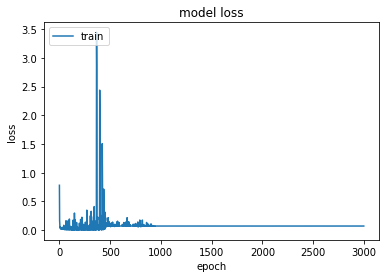

Procedure I
Statement  1:    1
Statement  2:    2
Statement  3:    3
Statement  4:    4
Statement  5:    5
Statement  6:    6
Statement  7:    7
Statement  8:    8
Statement  9:    9
Statement 10:   10
Statement 11:   11
Statement 12:   12
Statement 13:   13
Statement 14:   14
Statement 15:   15
Statement 16:   16
Statement 17:   17
Statement 18:   18
Statement 19:   19
Statement 20:   20
Statement 21:   21
Statement 22:   22
Statement 23:   23
Statement 24:   24
Statement 25:   25
Statement 26:   26
Statement 27:   27
Statement 28:   28
Statement 29:   29
Statement 30:   30
Statement 31:   31
Statement 32:   32
Statement 33:   33
Statement 34:   34
Statement 35:   35
Statement 36:   36
Statement 37:   37
Statement 38:   38
Statement 39:   39
Statement 40:   40
Statement 41:   41
Statement 42:   42
Statement 43:   43
Statement 44:   44
Statement 45:   45
Statement 46:   46
Statement 47:   47
Statement 48:   48
Statement 49:   49
Statement 50:   50
Statement 51:   51
Statement 52:   52


In [8]:
if __name__ == '__main__':
    inputstream = '../input/sort-bugxjy/bug_0_sort(line 6).csv'
    #n_statement = 90
    epochs = 3000
    lr = 0.03
    #m, result = get_train_data()
    m, result,n_statement = read_coverage(inputstream)
    trained_model = train_model(m,result, n_statement,epochs, lr)
    c_virtual = create_virtual_test(n_statement)
    r_virtual = trained_model.predict(c_virtual, batch_size=None, verbose=0, steps=None)
    procedure1(r_virtual)
    procedure2(r_virtual)